In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import colors as mcolors
import seaborn as sns
np.random.seed(1992) # para replicabilidad
# "Use seaborn style defaults and set the default figure size"
sns.set(rc={'figure.figsize':(15, 6)})

***Importación de datos basa en:*** <br>
https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/

In [3]:
precio_soya = pd.read_csv('soybean-prices.csv', sep= ',', index_col= 0, skiprows=3, parse_dates = True)
#precio_soya = pd.read_csv('soybean-prices.csv', sep = ',', index_col = 0, skiprows=3, parse_dates=[0])

In [4]:
# Add columns with year, month, and day name
precio_soya['Año'] = precio_soya.index.year
precio_soya['Mes'] = precio_soya.index.month
precio_soya['Dia semanal'] = precio_soya.index.weekday_name
# Para visualizar como quedó la nueva base (selecciona aleatoriamente 5 cols)

### Visualizar la base de datos

In [5]:
precio_soya.head()

,P_soya,Año,Mes,Dia semanal
date,,,,
2017-01-03,9.9500,2017,1,Tuesday
2017-01-04,10.1525,2017,1,Wednesday
2017-01-05,10.1250,2017,1,Thursday
2017-01-06,9.9475,2017,1,Friday
2017-01-09,10.0525,2017,1,Monday


In [6]:
precio_soya.tail()

,P_soya,Año,Mes,Dia semanal
date,,,,
2019-06-14,8.9675,2019,6,Friday
2019-06-17,9.1275,2019,6,Monday
2019-06-18,9.1350,2019,6,Tuesday
2019-06-19,9.0325,2019,6,Wednesday
2019-06-20,9.1550,2019,6,Thursday


In [7]:
precio_soya.describe()

,P_soya,Año,Mes
count,621.000000,621.000000,621.000000
mean,9.433614,2017.785829,5.933977
std,0.659359,0.741093,3.393612
min,8.025000,2017.000000,1.000000
25%,8.905000,2017.000000,3.000000
50%,9.467500,2018.000000,5.000000
75%,9.947500,2018.000000,9.000000
max,10.775000,2019.000000,12.000000


### Gráfica de los datos en niveles

Text(0.5, 1.0, 'Precio de la soya')

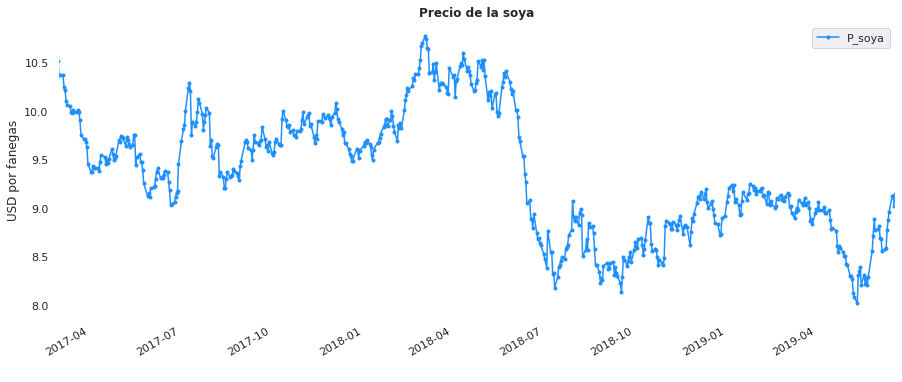

In [8]:
fech_ini= '2017-03-01'
fech_fin= '2019-06-20'

# Gráfica del precio de la soya
cols_plot = ['P_soya']

ax1 = precio_soya.loc[fech_ini: fech_fin, cols_plot].plot(linestyle='-', marker='.' ,color='dodgerblue') 
ax1.set_facecolor('white')
ax1.set_ylabel('USD por fanegas');
ax1.set_xlabel(' ');
ax1.set_title('Precio de la soya', fontweight='bold')

### Encontrar retornos log

In [9]:
# Crear variable de retornos e incluirla en el dataframe de pandas
ret_log = pd.DataFrame()
ret_log['Precio'] = np.log(precio_soya['P_soya']).diff().dropna()
ret_log.head()

,Precio
date,
2017-01-04,0.020147
2017-01-05,-0.002712
2017-01-06,-0.017686
2017-01-09,0.010500
2017-01-10,0.008420


In [10]:
retorno = ret_log['Precio'].mean()
volatilidad = ret_log['Precio'].std()

# Distribución de los retornos

Text(0.5, 1.0, 'Histograma de Retornos del precio de la soya: $\\mu=$-0.00013, $\\sigma=$0.0107')

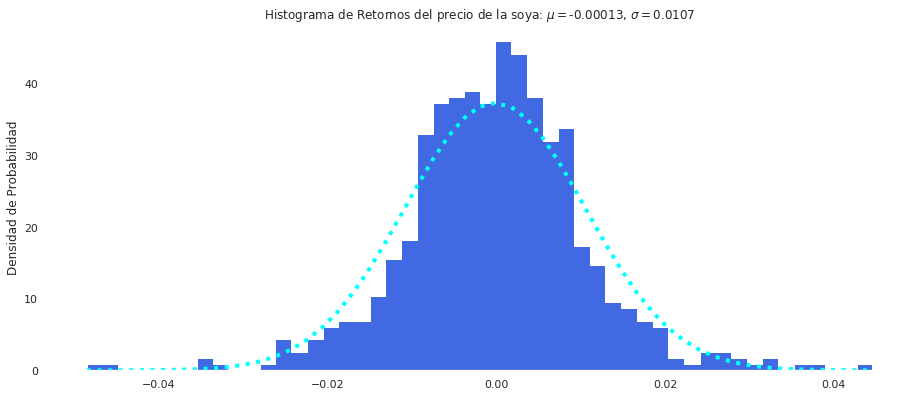

In [11]:
f2 = plt.figure(figsize=(15, 6))
ax2 = f2.add_axes([0.1,0.1,0.8,0.8])
ax2.set_facecolor('white')
n, bins, patches = ax2.hist(ret_log['Precio'], 50, density=True, histtype='stepfilled', color='royalblue')
y = ((1 / (np.sqrt(2 * np.pi) * volatilidad)) *
        np.exp(-0.5 * (1 / volatilidad * (bins - retorno))**2)) 
# Esto lo hace para graficar una dist normal con m y sd de la muestra de retornos, para comparación
ax2.plot(bins, y, ':', color='cyan', linewidth='4')

ax2.set_xlabel('')
ax2.set_ylabel('Densidad de Probabilidad')
ax2.set_title('Histograma de Retornos del precio de la soya: $\mu=$' +
             "{:,.5f}".format(retorno) +', $\sigma=$' + "{:,.4f}".format(volatilidad))

### Simulación

In [12]:
# arreglo de fechas
start = datetime.date(2019, 6, 20)
end = datetime.date(2019, 12, 31)
holidays = ['2019-12-24', datetime.date(2019, 12, 25), np.datetime64('2019-12-26')]
fechas = pd.bdate_range(start = start, end = end, freq = 'C', holidays = holidays)
fechas

DatetimeIndex(['2019-06-20', '2019-06-21', '2019-06-24', '2019-06-25',
               '2019-06-26', '2019-06-27', '2019-06-28', '2019-07-01',
               '2019-07-02', '2019-07-03',
               ...
               '2019-12-13', '2019-12-16', '2019-12-17', '2019-12-18',
               '2019-12-19', '2019-12-20', '2019-12-23', '2019-12-27',
               '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', length=136, freq='C')

**Obs:**
El modelo de simulación se define por:
<br><br>
$$
retornos_{i, sim} = \bar{R}_{soya} + X_{i} * vol_{soya}
$$
<br>
Donde $\bar{R}$ y $vol{ret}$, son el promedio y la volatilidad de los retornos de los precios de la soya, respectivamente. La variable $X_{i}$ se obtiene de draws aleatorios provenientes de la distrbiución normal estándar.

In [13]:
# simulación de las variaciones en los precios de la soya
num_dias = len(fechas)
num_sims = 10000

## Definir Matriz de simulaciones
sims = np.zeros((num_dias,num_sims))

## Definir Matriz de retornos aleatorios
ret = np.random.randn(num_dias , num_sims) * volatilidad + retorno

## Definir el primer flujo como el ahorro inicial
sims[0,] = np.exp(ret[0,]) * precio_soya['P_soya'].iloc[-1]


for i in range(1,num_dias):
    sims[i,] = sims[i-1,] * np.exp(ret[i,])

In [14]:
# Función definida para graficar
def graficar_percentiles_df(df):
    f = plt.figure(figsize=(17, 4))
    ax = plt.subplot(1, 2, 1)
    ax.plot(df.quantile(0.05, axis = 1), color = 'r', linewidth=4)
    ax.plot(df.mean(axis = 1), color = 'b', linewidth=4)
    ax.plot(df.quantile(0.95, axis = 1), color = 'g', linewidth=4)
    ax.plot(df.iloc[:,0:20], color = 'k' , alpha=0.15)
    ax.set_title('Utilidades Simuladas Mes a Mes')
    
    ax2 = plt.subplot(1, 2, 2)
    n, bins, patches = ax2.hist(df.sum(), 50, density=True)
    ax2.set_xlabel('Utilidades')
    ax2.set_ylabel('Densidad de Probabilidad')
    ax2.set_title('Histograma de Utilidad Anual. $EaR_{[90]} = $' + "{:,.1f}".format(df.sum().quantile(0.1)))
    ax2.axvline(x=df.sum().quantile(0.1), color='r')

In [15]:
percentil05 = np.percentile(sims,5,axis = 1)
percentil95 = np.percentile(sims,95,axis = 1)
promedio = sims.mean(axis = 1)

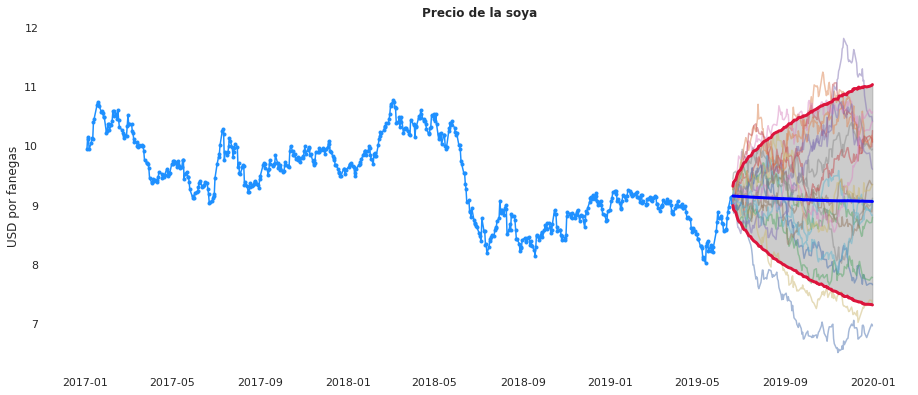

In [16]:
f3 = plt.figure(figsize=(15, 6))
ax3 = f3.add_axes([0.1,0.1,0.8,0.8])

ax3.set_facecolor('white')
ax3.plot(precio_soya['P_soya'], linestyle='-', marker='.' ,color='dodgerblue')
ax3.plot(fechas,sims[:,0:20], alpha=0.5)
plt.fill_between(fechas, percentil05, percentil95, where = percentil05 <= percentil95, color = 'grey', alpha = 0.4)
ax3.plot(fechas, percentil05, color = 'crimson', linewidth=3)
ax3.plot(fechas, promedio, color = 'blue', linewidth=3)
ax3.plot(fechas, percentil95, color = 'crimson', linewidth=3)
ax3.set_ylabel('USD por fanegas')
ax3.set_title('Precio de la soya', fontweight='bold')
ax3.grid(True)

### Calcular promedios diarios mes a mes

In [17]:
sims_df =  pd.DataFrame(sims, index = fechas).resample('M').mean()#.to_numpy()
sims_df

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
2019-06-30,8.964635,9.186083,9.310852,9.290306,9.280148,9.274267,9.448828,9.378327,9.050171,9.220071,...,9.415723,9.248767,9.149968,9.064807,9.403188,9.068660,9.392320,9.125254,9.270547,8.972232
2019-07-31,8.275916,9.434267,9.486871,9.557909,9.300218,8.972404,9.979335,9.820420,8.743062,8.986787,...,8.781426,8.732585,9.307635,9.220216,9.363625,9.451086,9.302062,9.095884,9.375408,8.947532
2019-08-31,7.724060,9.769900,9.464458,9.752057,9.603119,9.379898,10.355618,9.656443,8.138089,9.515152,...,8.534426,9.066092,9.463986,9.312256,8.955850,9.360926,9.150405,8.865218,9.962393,9.139211
2019-09-30,7.103272,10.348850,9.105724,9.882073,9.757850,9.081350,10.406709,9.527251,7.661924,8.640097,...,8.680697,9.368422,8.775474,9.314899,8.477151,8.782406,9.181650,8.787736,10.254425,8.722970
2019-10-31,6.830765,10.886807,8.751018,10.427437,10.136473,9.156454,10.631781,9.031055,7.444368,9.004325,...,8.940366,8.594882,8.815530,9.269195,8.152507,8.802755,9.200488,9.318935,10.144931,9.355573
2019-11-30,6.718351,10.717527,8.910714,10.744393,11.228684,9.136722,10.651695,8.247712,7.395763,9.300760,...,9.468250,8.210076,8.397511,9.265595,8.229047,9.165805,9.401344,9.602326,10.228796,10.035746
2019-12-31,6.897691,10.188676,8.694226,10.172327,11.122723,9.054817,10.344601,8.836521,7.218452,8.990667,...,9.444056,7.801275,7.795474,8.887913,7.671633,9.156951,8.934964,8.713517,10.520512,9.847927


## Tipo de cambio (MXN/USD)
El tipo de cambio se va a extraer usando pandas_datareader y extrayendo los datos de la página de la reserva federal de St. Louis (https://fred.stlouisfed.org/series/DEXMXUS).

In [18]:
import pandas_datareader as pdr
from pandas_datareader import data, wb

In [19]:
start_date_tc = datetime.datetime(2017, 1, 3)
end_date_tc = datetime.datetime(2019, 6, 20)
mxn_usd_tc = pdr.get_data_fred('DEXMXUS', start_date_tc, end_date_tc)

Text(0.5, 1.0, 'Tipo de cambio')

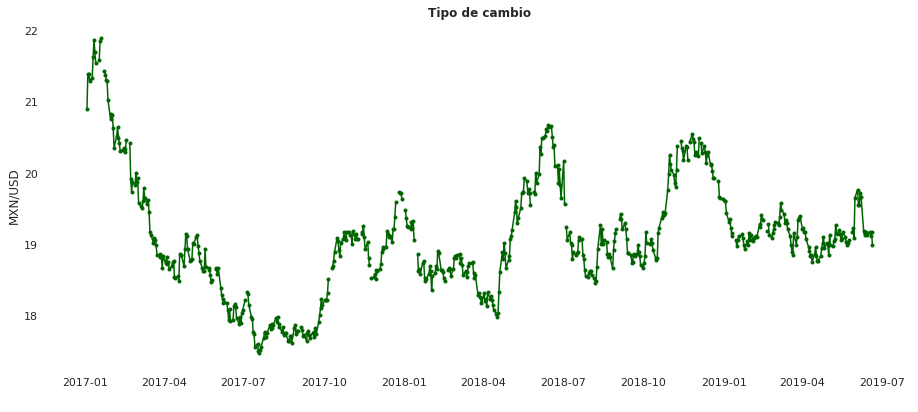

In [20]:
f4 = plt.figure(figsize=(15, 6))
ax4 = f4.add_axes([0.1,0.1,0.8,0.8])

ax4.set_facecolor('white')
ax4.plot(mxn_usd_tc, linestyle='-', marker='.' ,color='darkgreen')
ax4.set_facecolor('white')
ax4.set_ylabel('MXN/USD');
ax4.set_xlabel(' ');
ax4.set_title('Tipo de cambio', fontweight='bold')


In [21]:
mxn_usd_tc.describe()

,DEXMXUS
count,615.000000
mean,19.070850
std,0.811049
min,17.477500
25%,18.633000
50%,19.014500
75%,19.390250
max,21.891000


Text(0.5, 1.0, 'Histograma de las variaciones en tipo de cambio (MXN/USD: $\\mu=$-0.00018, $\\sigma=$0.0070')

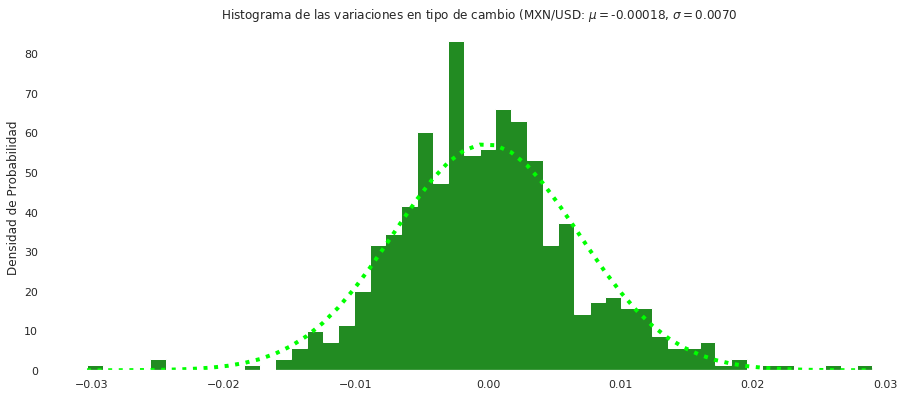

In [22]:
# Variaciones del tipo de cambio
# Crear variable de retornos e incluirla en el dataframe de pandas
tc_ret_log = pd.DataFrame()
tc_ret_log['delta_tc'] = np.log(mxn_usd_tc['DEXMXUS']).diff().dropna()

tc_retorno = tc_ret_log['delta_tc'].mean(); tc_retorno=  np.asscalar(tc_retorno)
tc_volatilidad = tc_ret_log['delta_tc'].std(); tc_volatilidad = np.asscalar(tc_volatilidad)

f5 = plt.figure(figsize=(15, 6))
ax5 = f5.add_axes([0.1,0.1,0.8,0.8])
ax5.set_facecolor('white')
n, bins, patches = ax5.hist(tc_ret_log['delta_tc'], 50, density=True, histtype='stepfilled', color='forestgreen')

tc_y = ((1 / (np.sqrt(2 * np.pi) * tc_volatilidad)) *
        np.exp(-0.5 * (1 / tc_volatilidad * (bins - tc_retorno))**2)) 

ax5.plot(bins, tc_y, ':', color='lime', linewidth='4')

ax5.set_xlabel('')
ax5.set_ylabel('Densidad de Probabilidad')
ax5.set_title('Histograma de las variaciones en tipo de cambio (MXN/USD: $\mu=$' +
             "{:,.5f}".format(tc_retorno) +', $\sigma=$' + "{:,.4f}".format(tc_volatilidad))

### Simulación del tipo de cambio
AL igual que en el caso anterior, la simulación del tipo de cambio (MXN/USD) se realiza con el siguiente modelo aleatorio. 
<br><br>
$$
TC_{i, sim} = \bar{TC} + X_{i} * vol_{tc}
$$
<br>
Donde $TC_{i, sim}$ es el tipo de cambio en el periodo $i$, $\bar{R}$ y $vol{ret}$, son el promedio y la volatilidad de las variaciones en la tasa de cambio, respectivamente. La variable $X_{i}$ se obtiene de draws aleatorios provenientes de la distrbiución normal estándar.

In [23]:
# arreglo de fechas
start = datetime.date(2019, 6, 20)
end = datetime.date(2019, 12, 31)
holidays = ['2019-12-24', datetime.date(2019, 12, 25), np.datetime64('2019-12-26')]
fechas = pd.bdate_range(start = start, end = end, freq = 'C', holidays = holidays)
fechas

# simulación de las variaciones en los precios de la soya
num_dias = len(fechas)
num_sims = 10000

## Definir Matriz de simulaciones
tc_sims = np.zeros((num_dias,num_sims))

## Definir Matriz de retornos aleatorios
tc_ret = np.random.randn(num_dias , num_sims) * tc_volatilidad + tc_retorno

## Definir el primer flujo como el ahorro inicial
tc_sims[0,] = np.exp(tc_ret[0,]) * mxn_usd_tc['DEXMXUS'].iloc[-1]


for i in range(1,num_dias):
    tc_sims[i,] = tc_sims[i-1,] * np.exp(tc_ret[i,])

In [24]:
tc_percentil05 = np.percentile(tc_sims,5,axis = 1)
tc_percentil95 = np.percentile(tc_sims,95,axis = 1)
tc_promedio = tc_sims.mean(axis = 1)

Text(0, 0.5, 'MXN/USD')

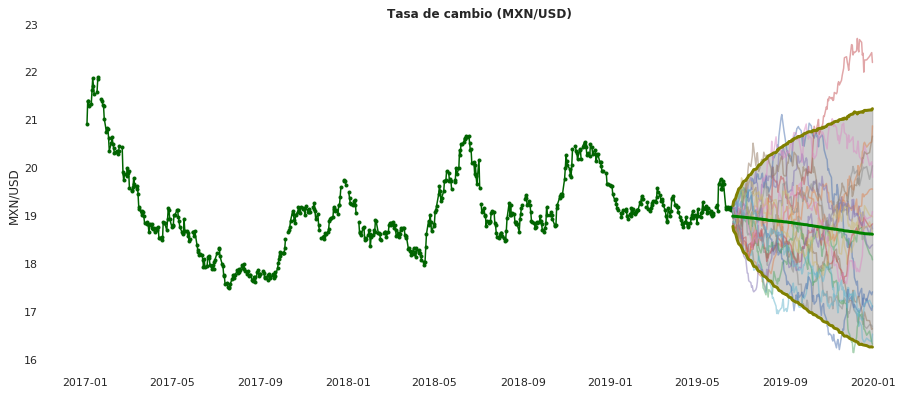

In [25]:
f6 = plt.figure(figsize=(15, 6))
ax6 = f6.add_axes([0.1,0.1,0.8,0.8])

ax6.set_facecolor('white')
ax6.plot(mxn_usd_tc['DEXMXUS'], linestyle='-', marker='.' ,color='darkgreen')
ax6.plot(fechas,tc_sims[:,0:20], alpha=0.5)
plt.fill_between(fechas, tc_percentil05, tc_percentil95, where = tc_percentil05 <= tc_percentil95, color = 'grey', alpha = 0.4)
ax6.plot(fechas, tc_percentil05, color = 'olive', linewidth=3)
ax6.plot(fechas, tc_promedio, color = 'green', linewidth=3)
ax6.plot(fechas, tc_percentil95, color = 'olive', linewidth=3)
ax6.set_title('Tasa de cambio (MXN/USD)', fontweight='bold')
ax6.set_ylabel('MXN/USD')

### Calcular promedios diarios mes a mes

In [26]:
tc_sims_df =  pd.DataFrame(tc_sims, index = fechas).resample('M').mean()#.to_numpy()
tc_sims_df.head()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
2019-06-30,19.150679,18.707825,18.979623,18.901928,19.067824,18.684957,19.097267,18.710960,19.393394,18.792310,...,19.008444,19.062439,18.940104,18.676446,18.941141,19.094504,18.705126,18.940105,18.788063,18.874812
2019-07-31,19.559255,18.114177,18.550469,18.439265,19.560812,19.169652,19.128291,18.663299,19.527679,18.166131,...,18.518663,19.865505,19.027810,18.433009,18.134420,18.890233,18.793533,18.499040,17.679167,19.104134
2019-08-31,20.197276,18.054361,17.614790,19.412538,19.934299,18.657373,20.223378,18.306001,18.907473,17.290451,...,18.731799,20.128509,18.961418,19.068687,17.401137,18.351483,19.638220,18.762157,16.879639,18.165702
2019-09-30,20.546965,19.182346,18.155401,19.457126,19.920798,18.490140,20.495403,17.792235,18.473342,17.284883,...,19.134051,20.318654,18.634773,19.904259,16.865667,18.284301,20.072734,19.094130,16.962923,16.685775
2019-10-31,20.564974,19.485449,18.461746,20.692015,19.603671,18.125476,20.549073,17.440874,18.557311,17.530045,...,19.378250,20.022989,19.122082,19.617724,16.893892,18.811125,19.348238,19.173154,17.003047,17.118681


### Utilidades de las empresas

#### Definir variables

In [27]:
# producción (asumo que es USD X bushels (fanegas))
# - muchos supuestos y no sé si aproximadamente funcione en el mundo real

alpha_exp = 0.8 # vamos a suponer que se exporta el 80% del cultivo de soya y que siempre es esa proporción
# esta diferencia pensando que al exportar hay se recibe el precio internacional, pero que en el mercado nacional se maneja otro precio,
# sin emabrgo no se ha incluído esto en el ejercicio. Pero se podría, es necesario tener las series del precio doméstico. 
# en este punto da totalmente igual poner esta partición de mercados


total_soya_prod = 5000 # en fanegas ¿Pueden producir siempre un número total de soya? ¿o también se simula?
tons_soya_nac = (1-alpha_exp)*total_soya_prod
tons_soya_exp = alpha_exp*total_soya_prod

# costos de producción (asumiendo que son determinísticos - no se simulan variaciones)
costo_prod_fan_soya = 4 # costo fijo de producir una fanegada de soya 
costo_vari_fan_soya = 2 # costo variable de producir una fanegada de soya 
costo_total_soya = total_soya_prod*(costo_prod_fan_soya + costo_vari_fan_soya)
# se deben poner costos diferenciados a la soya que se exporta y a la nacional? - si se hace la partición de mercados

**Obs:** Note que en este punto del ejercicio el choque de tasa de cambio afecta al total de ingresos sin diferenciar muy bien que son mercados diferentes el doméstico y el internacional. Si deseamos ajustar esto debemos incluir los precios domésticos de la soya en MXN.

#### Definir utilidades del exportador de soya

In [ ]:
costos_fijos_AAA = (15 / 100) * num_total_latas
ventas_AAA = (25 / 100) * num_total_latas
sims_util_AAA = (ventas_AAA - costos_fijos_AAA - sims_ventas_BBB).loc['2019-01-01':'2019-12-31']
graficar_percentiles_df(sims_util_AAA)

In [ ]:
start = datetime.date(2019, 6, 20)
end = datetime.date(2019, 12, 31)

sims_util_CCC = 0.1 * toneladas_mes * sims_df.shift(1).dropna().loc['2019-01-01':'2019-12-31']
graficar_percentiles_df(sims_util_CCC)

Utilidadesen MXN


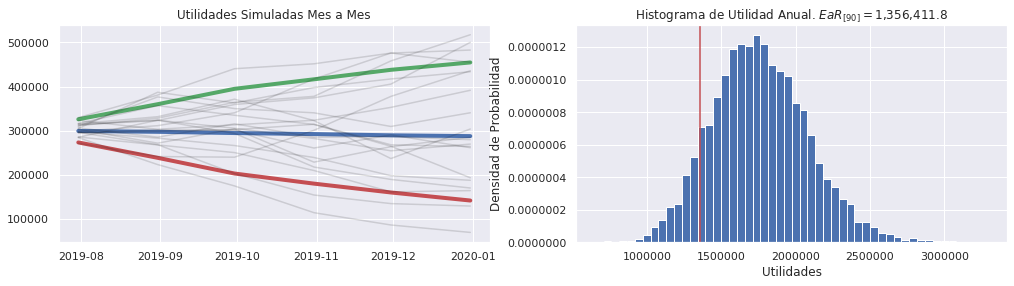

In [31]:
# ingresos 
precios_sim_prom = sims_df.shift(1).dropna().loc['2019-6-20':'2019-12-31']
tc_sim_prom = tc_sims_df.shift(1).dropna().loc['2019-6-20':'2019-12-31']

ing_tot_USD = (tons_soya_nac+ tons_soya_exp)*precios_sim_prom
ing_tot_MXN = ing_tot_USD*tc_sim_prom

# Utilidades

sim_utils_USD = (ing_tot_USD - costo_total_soya).loc['2019-6-20':'2019-12-31']
sim_utils_MXN = (tc_sim_prom*(ing_tot_USD - costo_total_soya)).loc['2019-6-20':'2019-12-31']

print('Utilidadesen MXN')
graficar_percentiles_df(sim_utils_MXN)

## Simulación conjunta con factorización de Cholesky